In [21]:
# imports
import time
tic = time.time()

import intake
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from xmip.preprocessing import combined_preprocessing
from xarrayutils.plotting import shaded_line_plot

from datatree import DataTree
from xmip.postprocessing import _parse_metric

%matplotlib inline

In [2]:
# open an intake catalog containing the Pangeo CMIP cloud data
col = intake.open_esm_datastore(
    "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
)

# pick the experiments you require
experiment_ids = ["historical", "ssp126", "ssp585"] #historical, future low-emissions and high-emissions scenarios

# from the full `col` object, create a subset using facet search
cat = col.search(
    source_id="TaiESM1",
    variable_id="tos",
    member_id="r1i1p1f1",
    table_id="Omon",
    grid_label="gn",
    experiment_id=experiment_ids,
    require_all_on=[
        "source_id"
    ],  # make sure that we only get models which have all of the above experiments
)

# convert the sub-catalog into a datatree object, by opening each dataset into an xarray.Dataset (without loading the data)
kwargs = dict(
    preprocess=combined_preprocessing,  # apply xMIP fixes to each dataset
    xarray_open_kwargs=dict(
        use_cftime=True
    ),  # ensure all datasets use the same time index
    storage_options={
        "token": "anon"
    },  # anonymous/public authentication to google cloud storage
)

cat.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
dt = cat.to_datatree(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


In [4]:
cat_area = col.search(
    source_id="TaiESM1",
    # Add the appropriate variable_id
    variable_id="areacello",
    member_id="r1i1p1f1",
    # Add the appropriate table_id
    table_id="Ofx",
    grid_label="gn",
    # Add the appropriate experiment_id
    experiment_id=["historical"],
    require_all_on=["source_id"],
)
cat_area.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
dt_area = cat_area.to_datatree(**kwargs)

dt_with_area = DataTree()

for model, subtree in dt.items():
    metric = dt_area[model]["historical"].ds["areacello"]
    dt_with_area[model] = subtree.map_over_subtree(_parse_metric, metric)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


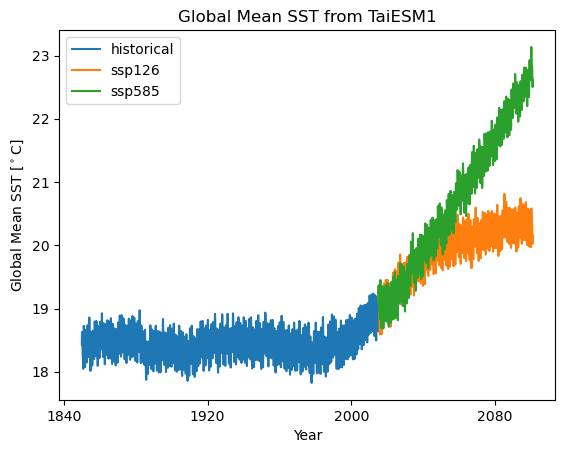

In [23]:
def global_mean(ds: xr.Dataset) -> xr.Dataset:
    """Global average, weighted by the cell area"""
    return ds.weighted(ds.areacello.fillna(0)).mean(["x", "y"], keep_attrs=True)


# average every dataset in the tree globally
dt_gm = dt_with_area.map_over_subtree(global_mean)
fig, ax = plt.subplots()
for experiment in ["historical", "ssp126", "ssp585"]:
    da = dt_gm["TaiESM1"][experiment].ds.tos
    da.plot(label=experiment, ax=ax)
ax.set_title("Global Mean SST from TaiESM1")
ax.set_ylabel("Global Mean SST [$^\circ$C]")
ax.set_xlabel("Year")
ax.legend() 